In [1]:
import numpy as np
import os
import watershed_udder as wu

dirpath = os.getcwd()
label_dir = os.path.join(dirpath, r"pred_labels")
kp_dir = os.path.join(label_dir, r"keypoints")
sg_dir = os.path.join(label_dir, r"segments")
im_dir = ""
out_dir = os.path.join(label_dir, r"watershed_segments")

# list of files
inpath = "frames_tosave"
array_path = "arrays"
file_list = os.listdir(array_path)

In [7]:
[file for file in file_list if "1282_20231117_121652" in file]

['1282_20231117_121652_depthframe_632.npy']

In [36]:
file_list.index(1282_20231117_121652_depthframe_632.npy')

SyntaxError: invalid decimal literal (292376987.py, line 1)

In [8]:


# for file in list  read content
for file in ['1282_20231117_121652_depthframe_632.npy']:#file_list:
    cow = file.split("_")[0]
    src = os.path.join(array_path, file)
    depth_array = np.load(src, mmap_mode="r")
    good_frames = "_".join(file.split("_")[:3]) +".txt"
    with open(os.path.join(inpath, good_frames), "r") as f:
        frames = f.read()
        if frames != "":
            frames = [int(num) for num in frames.split(",")]
            print(f"\n{cow}: {len(frames)}")
            cnt = 1
            for frame in frames[66:67]:
                file = "_".join(file.split("_")[:3]) +"_frame_" + str(frame) + ".tif"
                img = depth_array[frame]
                out_name = file.replace(".tif", ".npy")
                udder = wu.udder_object(file,im_dir, label_dir, img)
                udder_shp = udder.get_shape()
                udder_box = udder.get_box()
                points = udder.get_keypoints()
                udder_box = udder.get_keypoints()
                udder_mask = udder.get_mask()
                masked_udder = udder.img*udder_mask
                mask1 = np.zeros(udder.size)
                points2 =np.round(points,0).astype(int)
                
                lf_kp = points[0, :2]
                rf_kp = points[1, :2]
                lb_kp = points[2, :2]
                rb_kp = points[3, :2]

                new_front = wu.sep_points(rf_kp, lf_kp, udder_shp, udder_box)
                points2[0, :2] = new_front[0]
                points2[1, :2] = new_front[1]

                new_back = wu.sep_points(rb_kp, lb_kp, udder_shp, udder_box)
                points2[2, :2] = new_back[0]
                points2[3, :2] = new_back[1]

                labels = wu.watershed_labels(points2, udder)
                np.save(os.path.join(out_dir, out_name), labels)

                print(f"{cnt}: {file}")
                cnt +=1


1282: 483


ZeroDivisionError: division by zero

In [11]:
import numpy as np
from scipy import ndimage as ndi
import shapely
import math
import skimage as ski
import os
from skimage.morphology import dilation, square
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.restoration import inpaint


In [30]:
dil_factor = 30
ratio_limit = 4
iter_limit = 10

def area_ratio(labels):
    values = np.max(labels)
    areas = []
    for value in range(values):
        area = len(labels[labels==value+1])
        areas.append(area)
    return max(areas)/min(areas)

In [31]:
udder_mask = udder.get_mask()
masked_udder = udder.img*udder_mask
mask1 = np.zeros(udder.size)
# marker locations
mask1[points2[0, 1], points2[0,0]] = True
mask1[points2[1, 1], points2[1,0]] = True
mask1[points2[2, 1], points2[2,0]] = True
mask1[points2[3, 1], points2[3,0]] = True

mask1 = dilation(mask1,  square(dil_factor))
markers, _ = ndi.label(mask1)
# find segments
labels = watershed(masked_udder, markers = markers, mask = udder_mask, watershed_line=True)
# area of labels
ratio = area_ratio(labels)
cnt = 0
# print(f"{cnt} cow: {cow}, ratio: {ratio}")
while (ratio > ratio_limit) & (cnt < iter_limit): # and the number of segements is 4
    mask1 = dilation(mask1,  square(10))
    markers, _ = ndi.label(mask1)
    labels2 = watershed(masked_udder, markers = markers, mask = udder_mask, watershed_line=True)
    num_segments = np.max(labels2)
    if num_segments < 4:
        break
    else:
        labels = labels2
    ratio = area_ratio(labels)
    num_segments = np.max(labels2)

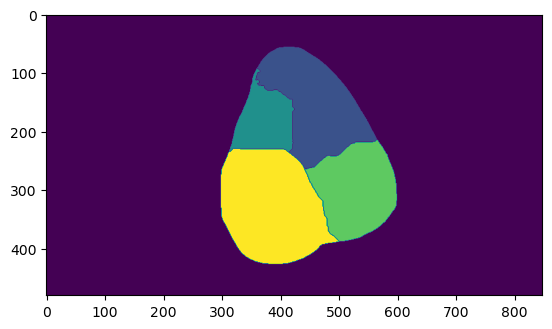

In [32]:
import matplotlib.pyplot as plt
plt.imshow(labels) 

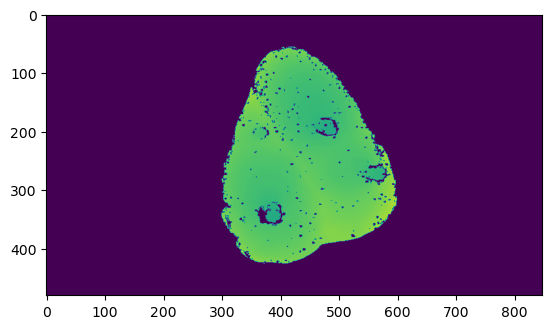

In [18]:
plt.imshow(masked_udder) 

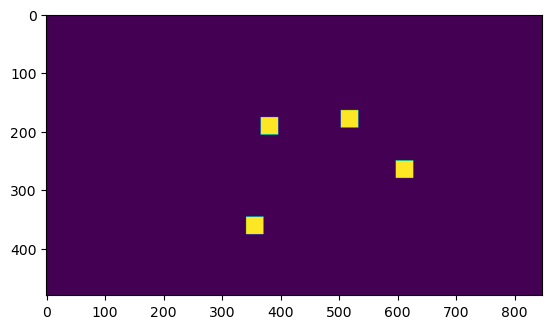

In [20]:
plt.imshow(mask1) 

In [35]:
values = np.max(labels)
for value in range(values):
    print(value+1)

1
2
3
4


In [22]:
values

4

In [27]:
values

array([1, 2, 4])